# What we are studying and why:
I set out to look at mental health, and after exploring some initial data narrowed my focus to studying mental health alongside alcohol use pre- and post-pandemic.  Covid 19 brought isolation, job loss, fear about remaining healthy, grief for those lost and loss of access to resources and community. I expected an increase when comparing pre and post-pandemic data for depression and anxiety as well as an uptick in alcohol use in that timeframe as many use alcohol during periods of stress.

Alcohol use is closely linked to mental health. Increased alcohol consumption can influence depression and anxiety, and poor mental health can drive alcohol use. 

By comparing data sets for depression and alcohol use alongside demographic data from the National Health and Nutrition Examination Survey (NHANES) data library, I hope to uncover how different populations experienced challenges of covid 19, and whether some groups were more or less at risk of mental health struggles than others.
Insights from this research could help shape mental health and substance abuse policies in different regions. It could be useful for health tech businesses wanting to provide services in specific states or regions as well as for staffing and funding of crisis hotlines and substance abuse programs. 



## Data Justification 
NHANES provides trusted demographic and health data suitable for studying depression and alcohol use across different demographics.
It covers years 2017–2023 and which gives an ideal range for pre and post pandemic data. Reddit offers another picture, which highlights a non-clinical self report of alcohol use. While reddit data is likely biased toward younger and more tech savvy individuals, it may offer a more intimate look at alcohol use outside of a clinical setting. People may be more inclined to disclose thier struggles anonymously on reddit than to their doctors, especailly if they are not seeking medical help with addicion. 






In [40]:
!pip install pandas pyreadstat 


In [41]:
import numpy as np
import pandas as pd
import os
from scipy.stats import ttest_ind
 

In [43]:


# File paths to years 2013-2023 for demographic, depression, and alcohol use surveys 
# from CDC website "National Health and Nutrition Examenation Survey"
file_paths = [
    "P_DPQ_2017-2020-pre.xpt", 
    "P_ALQ_2017-2020-pre.xpt", "P_DEMO_2017-2020-pre.xpt", 
    "DPQ_L_2021-2023.xpt",
    "ALQ_L_2021-2023.xpt", "DEMO_L_2021-2023.xpt"
]

# Load each file into dictionary of DataFrames
dataframes = {}
for file in file_paths:
    key = os.path.splitext(os.path.basename(file))[0]  # Use filename as key
    dataframes[key] = pd.read_sas(file, format="xport")

# Check loaded files
for key, df in dataframes.items():
    print(f"{key}: {df.shape}")


P_DPQ_2017-2020-pre: (8965, 11)
P_ALQ_2017-2020-pre: (8965, 10)
P_DEMO_2017-2020-pre: (15560, 29)
DPQ_L_2021-2023: (6337, 11)
ALQ_L_2021-2023: (6337, 9)
DEMO_L_2021-2023: (11933, 27)


In [44]:
# Merge 2017-2020 files
dpq_2017 = dataframes['P_DPQ_2017-2020-pre']
alq_2017 = dataframes['P_ALQ_2017-2020-pre']
demo_2017 = dataframes['P_DEMO_2017-2020-pre']

# Merge using SEQN
merged_2017 = demo_2017.merge(dpq_2017, on="SEQN", how="inner") \
                       .merge(alq_2017, on="SEQN", how="left")                    

# Merge 2021-2023 files
dpq_2021 = dataframes['DPQ_L_2021-2023']
alq_2021 = dataframes['ALQ_L_2021-2023']
demo_2021 = dataframes['DEMO_L_2021-2023']

# Merge using SEQN
merged_2021 = demo_2021.merge(dpq_2021, on="SEQN", how="inner") \
                       .merge(alq_2021, on="SEQN", how="left") 

In [45]:
# Combine all year blocks
combined_df = pd.concat([merged_2017, merged_2021], ignore_index=True)

# Check combined dataset
print(combined_df.shape)
print(combined_df.head())

(15302, 59)
       SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  109266.0      66.0       2.0       2.0      29.0       NaN       5.0   
1  109271.0      66.0       2.0       1.0      49.0       NaN       3.0   
2  109273.0      66.0       2.0       1.0      36.0       NaN       3.0   
3  109274.0      66.0       2.0       1.0      68.0       NaN       5.0   
4  109282.0      66.0       2.0       1.0      76.0       NaN       3.0   

   RIDRETH3  RIDEXMON  DMDBORN4  ...  DMQMILIZ  DMDYRUSR  DMDHHSIZ  DMDHRGND  \
0       6.0       2.0       2.0  ...       NaN       NaN       NaN       NaN   
1       3.0       2.0       1.0  ...       NaN       NaN       NaN       NaN   
2       3.0       2.0       1.0  ...       NaN       NaN       NaN       NaN   
3       7.0       1.0       1.0  ...       NaN       NaN       NaN       NaN   
4       3.0       2.0       1.0  ...       NaN       NaN       NaN       NaN   

   DMDHRAGZ  DMDHREDZ  DMDHRMAZ  DMDHSEDZ  WTINT2YR  WTM

# But what the heck are all these codes? 
The NHANES data was very comprehensive but required the use of codebooks that create consistency across the 2 year increments data is typically collected in. I matched the codebooks for 2021-23 alcohol, depression and demograpic data to the codes across the whole combined dataset to create a set of parameters that extends across all years pre and post-pandemic. 

In [46]:
# Make original column readable using codebooks
column_mapping = {
    'SEQN': 'Respondent sequence number',
    'SDDSRVYR': 'Data release cycle',
    'RIDSTATR': 'Interview/Examination status',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age in years at screening',
    'RIDAGEMN': 'Age in months at screening (0-24 months)',
    'RIDRETH1': 'Race/Hispanic origin',
    'RIDRETH3': 'Race/Hispanic origin with NH Asian',
    'RIDEXMON': 'Six-month time period',
    'RIDEXAGM': 'Age in months at exam (0-19 years)',
    'DMQMILIZ': 'Served active duty in US Armed Forces',
    'DMDBORN4': 'Country of birth',
    'DMDYRUSR': 'Length of time in US',
    'DMDEDUC2': 'Education level (Adults 20+)',
    'DMDMARTZ': 'Marital status',
    'RIDEXPRG': 'Pregnancy status at exam',
    'DMDHHSIZ': 'Total number of people in the household',
    'DMDHRGND': 'Household reference person’s gender',
    'DMDHRAGZ': 'Household reference person’s age in years',
    'DMDHREDZ': 'Household reference person’s education level',
    'DMDHRMAZ': 'Household reference person’s marital status',
    'DMDHSEDZ': 'Household reference person’s spouse’s education level',
    'WTINT2YR': 'Full sample 2-year interview weight',
    'WTMEC2YR': 'Full sample 2-year MEC exam weight',
    'WTINTPRP': 'Full sample interview weight',
    'WTMECPRP': 'Full sample MEC exam weight',
    'SDMVSTRA': 'Masked variance pseudo-stratum',
    'SDMVPSU': 'Masked variance pseudo-PSU',
    'INDFMPIR': 'Ratio of family income to poverty',
    'ALQ111': 'Ever had a drink of any kind of alcohol',
    'ALQ121': 'Past 12 months how often drink alcohol beverage',
    'ALQ130': 'Average number of alcoholic drinks/day in past 12 months',
    'ALQ142': 'Number of days had 4/5 drinks in past 12 months',
    'ALQ290': 'Times 12+ drinks in 1 day/past 12 mos',
    'ALQ270': 'Number of times had 4/5 drinks in 2 hours (past 12 months)',
    'ALQ280': 'Number of times had 8+ drinks in 1 day (past 12 months)',
    'ALQ151': 'Ever had 4/5 or more drinks every day',
    'ALQ170': 'Number of times had 4/5 drinks on occasion (past month)',
    'DPQ010': 'Little interest in doing things',
    'DPQ020': 'Feeling down, depressed, or hopeless',
    'DPQ030': 'Trouble sleeping or sleeping too much',
    'DPQ040': 'Feeling tired or having little energy',
    'DPQ050': 'Poor appetite or overeating',
    'DPQ060': 'Feeling bad about yourself',
    'DPQ070': 'Trouble concentrating on things',
    'DPQ080': 'Moving or speaking slowly or too fast',
    'DPQ090': 'Thought you would be better off dead',
    'DPQ100': 'Difficulty these problems have caused',
}

In [47]:
# Create anotehr DataFrame with readable columns
readable_df = combined_df.rename(columns=column_mapping)

#Check first few rows and ensure all cols are there 
print(readable_df.head())
print(readable_df.columns)

# make a new csv of combined data with readable names
readable_df.to_csv('nhanes_columns_readable.csv', index=False)

   Respondent sequence number  Data release cycle  \
0                    109266.0                66.0   
1                    109271.0                66.0   
2                    109273.0                66.0   
3                    109274.0                66.0   
4                    109282.0                66.0   

   Interview/Examination status  Gender  Age in years at screening  \
0                           2.0     2.0                       29.0   
1                           2.0     1.0                       49.0   
2                           2.0     1.0                       36.0   
3                           2.0     1.0                       68.0   
4                           2.0     1.0                       76.0   

   Age in months at screening (0-24 months)  Race/Hispanic origin  \
0                                       NaN                   5.0   
1                                       NaN                   3.0   
2                                       NaN          

### I saved this as a readable data frame

Comparing the codebooks for 2021-23 Alcohol, Depression and Demographics, a more readable data set can be created. Now I am able to make some decisions about which data can help with my research questions.


## Research Questions:
How have trends in mental health (specifically depression) evolved pre and post-pandemic?

Was there a related change in alcohol consumption during this period?

Did these changes differ over demographics like age, gender and race?

Does the pandemic impact the way alcohol addiction is discussed on social media (reddit r/stopdrinking, r/AskReddit)? 
## Hypotheses:
Depression and anxiety increased post-pandemic.

Alcohol use increased during the pandemic and may contribute to negative mental health.

Increased negative sentiment of alcohol on reddit after the pandemic. 

In [48]:
# keep only relevant variables
columns_needed = [
    'Data release cycle',
    'Little interest in doing things',
    'Feeling down, depressed, or hopeless',
    'Trouble sleeping or sleeping too much',
    'Feeling tired or having little energy',
    'Poor appetite or overeating',
    'Feeling bad about yourself',
    'Thought you would be better off dead',
    'Ever had a drink of any kind of alcohol',
    'Past 12 months how often drink alcohol beverage',
    'Average number of alcoholic drinks/day in past 12 months',
    'Number of days had 4/5 drinks in past 12 months',
    'Gender',
    'Age in years at screening',
    'Race/Hispanic origin',
    'Full sample 2-year interview weight',
    'Full sample 2-year MEC exam weight',
    'Masked variance pseudo-PSU',
    'Masked variance pseudo-stratum',
    'Full sample interview weight',
    'Full sample MEC exam weight',
]

subset_data = readable_df[columns_needed]

# make new CSV file 
subset_data.to_csv("mental_health_alcohol_data.csv", index=False)

# Dlook at first rows
subset_data.head()



,Data release cycle,Little interest in doing things,"Feeling down, depressed, or hopeless",Trouble sleeping or sleeping too much,Feeling tired or having little energy,Poor appetite or overeating,Feeling bad about yourself,Thought you would be better off dead,Ever had a drink of any kind of alcohol,Past 12 months how often drink alcohol beverage,...,Number of days had 4/5 drinks in past 12 months,Gender,Age in years at screening,Race/Hispanic origin,Full sample 2-year interview weight,Full sample 2-year MEC exam weight,Masked variance pseudo-PSU,Masked variance pseudo-stratum,Full sample interview weight,Full sample MEC exam weight
0,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.000000e+01,...,5.397605e-79,2.0,29.0,5.0,NaN,NaN,2.0,168.0,7825.646112,8154.968193
1,66.0,2.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,5.397605e-79,...,NaN,1.0,49.0,3.0,NaN,NaN,1.0,167.0,8481.589837,8658.732873
2,66.0,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.397605e-79,1.0,5.397605e-79,...,NaN,1.0,36.0,3.0,NaN,NaN,1.0,155.0,20171.847767,22163.596850
3,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,4.000000e+00,...,5.000000e+00,1.0,68.0,5.0,NaN,NaN,2.0,167.0,7227.993241,7801.600218
4,66.0,5.397605e-79,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.0,5.397605e-79,...,NaN,1.0,76.0,3.0,NaN,NaN,2.0,164.0,28363.015286,31816.346500


In [63]:
# map each column of data to values that are readable from the codebooks

mappings = {
    'Data release cycle': {66: "2017–2020 (Pre-Pandemic)", 12: "2021–2023 (Post-Pandemic)"},
    'Gender': {1: "Male", 2: "Female"},
    'Age in years at screening': {80: "80 years or older"},  
    'Race/Hispanic origin': {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        5: "Other Race - Including Multi-Racial"
    },
    'Race/Hispanic origin with NH Asian': {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        6: "Non-Hispanic Asian",
        7: "Other Race - Including Multi-Racial"
    },
    'Little interest in doing things': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Feeling down, depressed, or hopeless': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Trouble sleeping or sleeping too much': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Feeling tired or having little energy': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Poor appetite or overeating': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Feeling bad about yourself': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Thought you would be better off dead': {0: "Not at all", 1: "Several days", 2: "More than half the days", 3: "Nearly every day"},
    'Ever had a drink of any kind of alcohol': {1: "Yes", 2: "No", 777: "Refused", 999: "Don't know"},
    'Past 12 months how often drink alcohol beverage': {
        0: "Never in the last year", 1: "Every day", 2: "Nearly every day", 3: "3 to 4 times a week",
        4: "2 times a week", 5: "Once a week", 6: "2 to 3 times a month", 7: "Once a month",
        8: "7 to 11 times in the last year", 9: "3 to 6 times in the last year",
        10: "1 to 2 times in the last year", 77: "Refused", 99: "Don't know"
    },
    'Average number of alcoholic drinks/day in past 12 months': {777: "Refused", 999: "Don't know"},  
    'Number of days had 4/5 drinks in past 12 months': {
        0: "Never in the last year", 1: "Every day", 2: "Nearly every day", 3: "3 to 4 times a week",
        4: "2 times a week", 5: "Once a week", 6: "2 to 3 times a month", 7: "Once a month",
        8: "7 to 11 times in the last year", 9: "3 to 6 times in the last year",
        10: "1 to 2 times in the last year", 77: "Refused", 99: "Don't know"
    },
}

# Create a new copy of the DataFrame to work on
readable_subset = subset_data.copy()

# Apply the mappings for the column values
for column, mapping in mappings.items():
    if column in readable_subset.columns:
        readable_subset.loc[:, column] = readable_subset[column].replace(mapping)

# Display the updated DataFrame
print(readable_subset.head())

         Data release cycle Little interest in doing things  \
0  2017–2020 (Pre-Pandemic)                             0.0   
1  2017–2020 (Pre-Pandemic)         More than half the days   
2  2017–2020 (Pre-Pandemic)         More than half the days   
3  2017–2020 (Pre-Pandemic)                             0.0   
4  2017–2020 (Pre-Pandemic)                             0.0   

  Feeling down, depressed, or hopeless Trouble sleeping or sleeping too much  \
0                                  0.0                                   0.0   
1                         Several days                                   0.0   
2              More than half the days               More than half the days   
3                                  0.0                                   0.0   
4                         Several days                                   0.0   

  Feeling tired or having little energy Poor appetite or overeating  \
0                                   0.0                         0.0  

/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_72608/4114314864.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2017–2020 (Pre-Pandemic)' '2017–2020 (Pre-Pandemic)'
 '2017–2020 (Pre-Pandemic)' ... '2021–2023 (Post-Pandemic)'
 '2021–2023 (Post-Pandemic)' '2021–2023 (Post-Pandemic)']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  readable_subset.loc[:, column] = readable_subset[column].replace(mapping)
/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_72608/4114314864.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Female' 'Male' 'Male' ... 'Male' 'Male' 'Female']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  readable_subset.loc[:, column] = readable_subset[column].replace(mapping)
/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0

In [35]:
missing_summary = readable_subset.isnull().sum().sort_values(ascending=False)
missing_percent = (readable_subset.isnull().mean() * 100).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Count': missing_summary, 'Missing Percent': missing_percent})
print(missing_data)


                                                    Missing Count  \
Full sample 2-year interview weight                          8965   
Full sample 2-year MEC exam weight                           8965   
Full sample MEC exam weight                                  6337   
Full sample interview weight                                 6337   
Average number of alcoholic drinks/day in past ...           5370   
Number of days had 4/5 drinks in past 12 months              5357   
Past 12 months how often drink alcohol beverage              2877   
Thought you would be better off dead                         1494   
Feeling bad about yourself                                   1488   
Poor appetite or overeating                                  1484   
Feeling tired or having little energy                        1483   
Trouble sleeping or sleeping too much                        1480   
Feeling down, depressed, or hopeless                         1478   
Little interest in doing things   

In [50]:
# It seems missing weights have to do with the data release cycle
weight_missing_by_cycle = readable_subset.groupby('Data release cycle')[[
    'Full sample 2-year interview weight',
    'Full sample 2-year MEC exam weight',
    'Full sample MEC exam weight',
    'Full sample interview weight'
]].apply(lambda x: x.isnull().mean() * 100)
print(weight_missing_by_cycle)

                           Full sample 2-year interview weight  \
Data release cycle                                               
2017–2020 (Pre-Pandemic)                                 100.0   
2021–2023 (Post-Pandemic)                                  0.0   

                           Full sample 2-year MEC exam weight  \
Data release cycle                                              
2017–2020 (Pre-Pandemic)                                100.0   
2021–2023 (Post-Pandemic)                                 0.0   

                           Full sample MEC exam weight  \
Data release cycle                                       
2017–2020 (Pre-Pandemic)                           0.0   
2021–2023 (Post-Pandemic)                        100.0   

                           Full sample interview weight  
Data release cycle                                       
2017–2020 (Pre-Pandemic)                            0.0  
2021–2023 (Post-Pandemic)                         100.0  


## What are weights? 

Weights in survey data ensure that the results are representative of the population. They compensate for oversampling, non-responses, and differences in the probability of selection.

### How do we handle other missing data?

Data imputation is the process of replacing missing values in a dataset with estimated values using prediction methods. Depending on the charactersitics of the missing data there are different approaches 

#### Low to somewhat moderate missing data for alcohol survey
Number of days had 4/5 drinks in past 12 months:           **35%** \
Past 12 months how often drink alcohol beverage:           **18%**

#### Low missing data for depression survey:
Thought you would be better off dead                       **9.7%** \
Feeling bad about yourself                                 **9.7%** \
Poor appetite or overeating                                **9.6%** \
Feeling tired or having little energy                      **9.6%** \
Trouble sleeping or sleeping too much                      **9.6%** \
Feeling down, depressed, or hopeless                       **9.6%** \
Little interest in doing things                            **9.6%** \
Ever had a drink of any kind of alcohol                    **9.4%**
#### Data randomness 
Determining whether missing values are random or not is crucial for handling missing data appropriately. 
If missing values are randomly distributed across all variables, this suggests missing values are random.

In [52]:
# Create missingness indicators
cols_to_check = [
    'Number of days had 4/5 drinks in past 12 months',
    'Past 12 months how often drink alcohol beverage',
    'Thought you would be better off dead',
    'Feeling bad about yourself',
    'Poor appetite or overeating',
    'Feeling tired or having little energy',
    'Trouble sleeping or sleeping too much',
    'Feeling down, depressed, or hopeless',
    'Little interest in doing things',
    'Ever had a drink of any kind of alcohol'
]

for col in cols_to_check:
    readable_subset[f'{col}_missing'] = readable_subset[col].isnull()



In [59]:
# to avoid errors with age data in non numeric form
 
#Convert to Numeric Convert the Age in years at screening column to numeric, making any invalid entries to NaN (coerce)
readable_subset['Age in years at screening'] = pd.to_numeric(readable_subset['Age in years at screening'], errors='coerce')
print(readable_subset['Age in years at screening'].dtype)

float64


In [60]:
from scipy.stats import ttest_ind

for col in cols_to_check:
    missing_col = f'{col}_missing'
    
    group_missing = readable_subset.loc[readable_subset[missing_col], 'Age in years at screening']
    group_not_missing = readable_subset.loc[~readable_subset[missing_col], 'Age in years at screening']
    
    # Perform t-test
    t_stat, p_val = ttest_ind(group_missing.dropna(), group_not_missing.dropna(), nan_policy='omit')
    
    print(f"Column: {col}")
    print(f"T-statistic for Age: {t_stat:.4f}, P-value: {p_val:.4f}")
    print("-" * 40)


Column: Number of days had 4/5 drinks in past 12 months
T-statistic for Age: 14.6813, P-value: 0.0000
----------------------------------------
Column: Past 12 months how often drink alcohol beverage
T-statistic for Age: -5.2509, P-value: 0.0000
----------------------------------------
Column: Thought you would be better off dead
T-statistic for Age: -0.1689, P-value: 0.8659
----------------------------------------
Column: Feeling bad about yourself
T-statistic for Age: -0.1582, P-value: 0.8743
----------------------------------------
Column: Poor appetite or overeating
T-statistic for Age: -0.1999, P-value: 0.8416
----------------------------------------
Column: Feeling tired or having little energy
T-statistic for Age: -0.2253, P-value: 0.8217
----------------------------------------
Column: Trouble sleeping or sleeping too much
T-statistic for Age: -0.2696, P-value: 0.7875
----------------------------------------
Column: Feeling down, depressed, or hopeless
T-statistic for Age: -0.35

### Randomness Explained: 

A high absolute value of t-statistic means the difference is large compared to the variability.
A P-value < 0.05 means the difference is statistically significant and unlikely to have happened by chance.

**Alcohol Survey Questions**
The missingness in "Number of days had 4/5 drinks" and "Past 12 months how often drink alcohol beverage" is not random, as there is significant age difference in responses and this suggests a relationship between missingness and age. This could highlight biases in responses from different age groups.\
Since the missing data for alcohol is not random and is related to age, we shoudl use a regression model to predict the missing values. 
 
**Depression Survey Questions** 
The missingness in all depression-related variables appears to be random (MCAR), as there is no significant age difference between groups with and without missing data.


## A roadblock:

To understand the data in my combined dataset, I'd renamed all the columns and data to make them more readable. In doing this I lost the formatting. When I tried to run regression models to predict missing data, I found I was blocked by this. To resolve it I made a version of the narrowed data set using the old column keys and numeric values for the data so that I could perform modeling on the original data set while referring to a readable data set I could easily understand without constantly referring to the codebooks. I'm not sure whether medical data scientists memorise all the codes or not, but found this a more usable solution.

In [134]:
# back it up: 
# Reverse the column_mapping dictionary
reverse_mapping = {v: k for k, v in column_mapping.items()}

# Get original column names corresponding to the needed columns
needed_keys = [reverse_mapping[col] for col in columns_needed if col in reverse_mapping]

# Create a new DataFrame with only the needed columns
filtered_og = combined_df[needed_keys].copy()

# Display the new DataFrame
filtered_og.head()



,SDDSRVYR,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ090,ALQ111,ALQ121,...,ALQ142,RIAGENDR,RIDAGEYR,RIDRETH1,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,WTINTPRP,WTMECPRP
0,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.000000e+01,...,5.397605e-79,2.0,29.0,5.0,NaN,NaN,2.0,168.0,7825.646112,8154.968193
1,66.0,2.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,5.397605e-79,...,NaN,1.0,49.0,3.0,NaN,NaN,1.0,167.0,8481.589837,8658.732873
2,66.0,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.397605e-79,1.0,5.397605e-79,...,NaN,1.0,36.0,3.0,NaN,NaN,1.0,155.0,20171.847767,22163.596850
3,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,4.000000e+00,...,5.000000e+00,1.0,68.0,5.0,NaN,NaN,2.0,167.0,7227.993241,7801.600218
4,66.0,5.397605e-79,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.0,5.397605e-79,...,NaN,1.0,76.0,3.0,NaN,NaN,2.0,164.0,28363.015286,31816.346500


Now we have the combined and narrowed data set with the original values to do the imputations on 🥳 First set predictors and target columns to numeric and define them



In [113]:
# copy data to replacing missing 
data_to_impute = filtered_og.copy()

# make predictors and target columns numeric
data_to_impute['RIAGENDR'] = data_to_impute['RIAGENDR'].astype(float)
data_to_impute['RIDAGEYR'] = data_to_impute['RIDAGEYR'].replace(80, np.nan).astype(float)  # makes 80 like a missing value
data_to_impute['RIDRETH1'] = data_to_impute['RIDRETH1'].astype(float)

predictors = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1']
target_columns = ['ALQ142', 'ALQ121']


In [114]:
from sklearn.impute import SimpleImputer
predictor_imputer = SimpleImputer(strategy='mean')

# Impute missing predictors with the mean
data_to_impute[predictors] = predictor_imputer.fit_transform(data_to_impute[predictors])


In [115]:
from sklearn.linear_model import LinearRegression
import numpy as np

def impute_with_regression(data, target_col, predictors):
    # Split data into rows with and without missing target values
    data_non_missing = data.dropna(subset=[target_col])
    data_missing = data[data[target_col].isnull()]

    # Prepare training data
    X_train = data_non_missing[predictors]
    y_train = data_non_missing[target_col]

    # Fit regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict missing values
    X_missing = data_missing[predictors]
    data.loc[data[target_col].isnull(), target_col] = model.predict(X_missing)
    return data


In [116]:
# Impute missing values for target columns
for col in target_columns:
    data_to_impute = impute_with_regression(data_to_impute, col, predictors)


In [117]:
print("missing values:")
print(data_to_impute[target_columns].isnull().sum())


missing values:
ALQ142    0
ALQ121    0
dtype: int64


In [120]:
# Select columns for imputation
columns_for_knn = [
    'DPQ090', 'DPQ060', 'DPQ050', 'DPQ040', 
    'DPQ030', 'DPQ020', 'DPQ010', 'ALQ111',
    'RIDAGEYR', 'RIAGENDR', 'RIDRETH1'  # Add predictors
]

# Create a subset of the data
data_for_imputation = data_to_impute[columns_for_knn]


In [121]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_imputation)



In [126]:
from sklearn.impute import KNNImputer

# Initialize and fit the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)  # Use 5 neighbors
imputed_data = knn_imputer.fit_transform(scaled_data)


In [127]:

# Inverse transform the data
imputed_data = scaler.inverse_transform(imputed_data)


In [128]:
# Convert to DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=columns_for_knn)

# Update the original dataset
data_to_impute.update(imputed_data_df)

# Check if missing values are handled
print("Remaining missing values:")
print(data_to_impute[columns_for_knn].isnull().sum())


Remaining missing values:
DPQ090      0
DPQ060      0
DPQ050      0
DPQ040      0
DPQ030      0
DPQ020      0
DPQ010      0
ALQ111      0
RIDAGEYR    0
RIAGENDR    0
RIDRETH1    0
dtype: int64


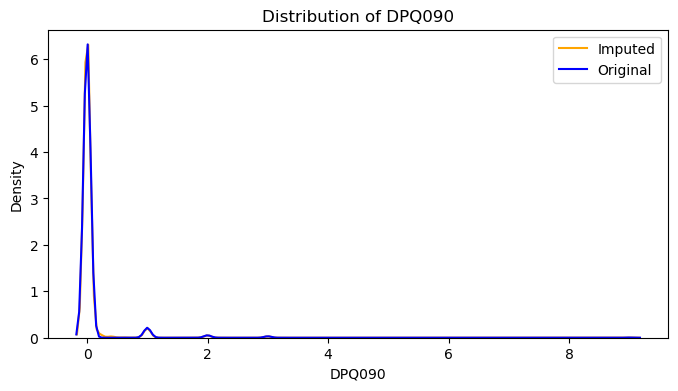

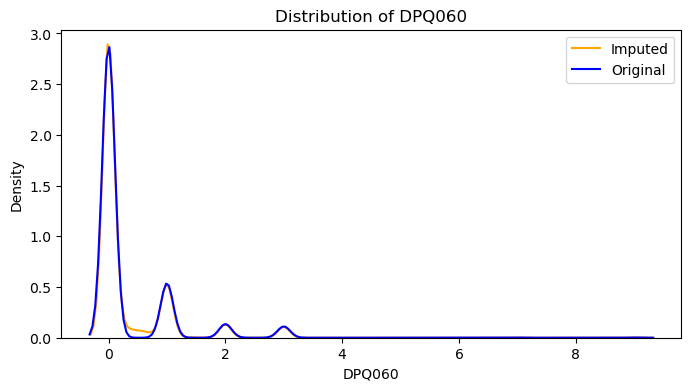

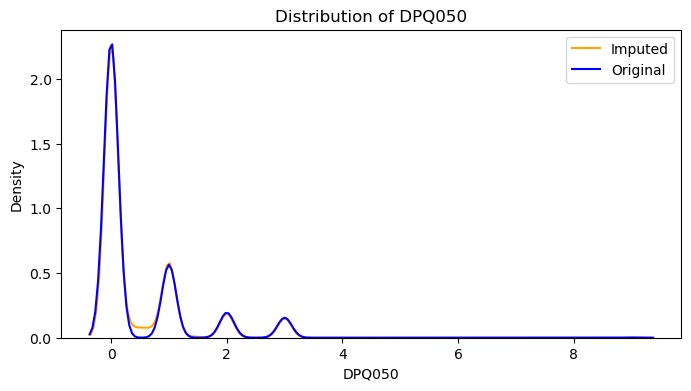

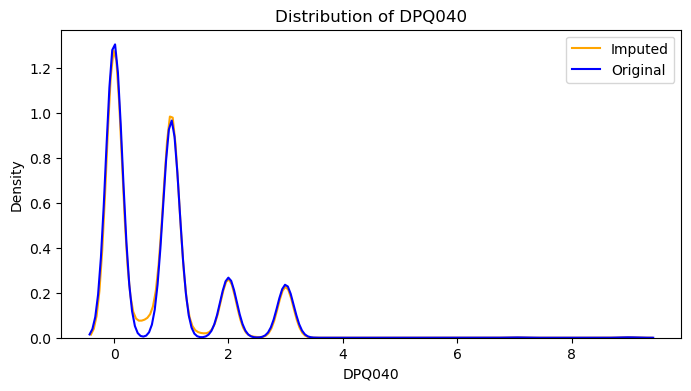

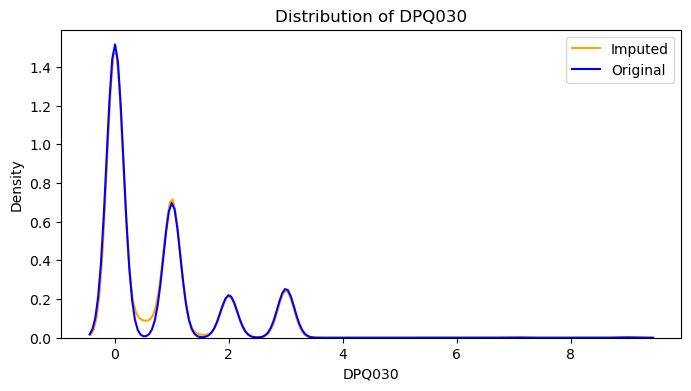

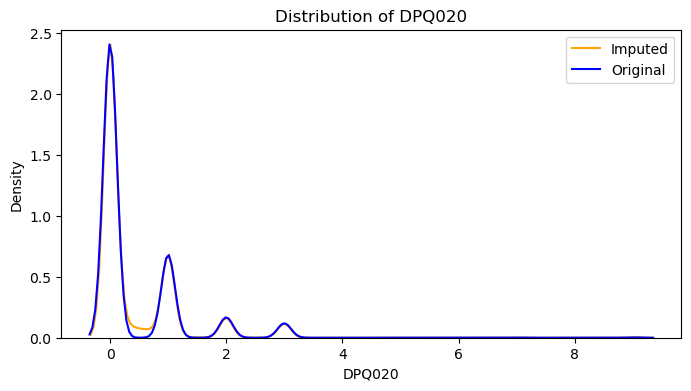

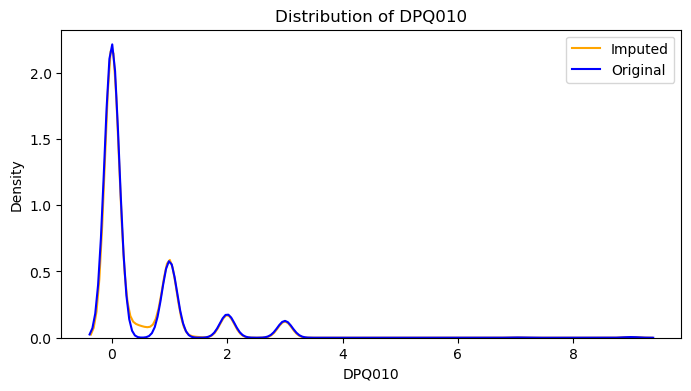

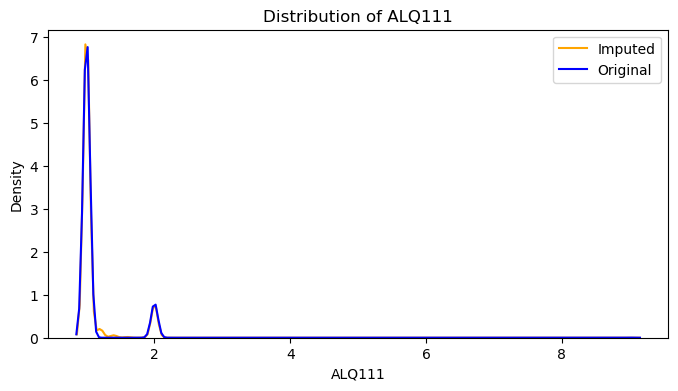

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['DPQ090', 'DPQ060', 'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020', 'DPQ010', 'ALQ111']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data_to_impute[col].dropna(), label='Imputed', color='orange')
    sns.kdeplot(filtered_og[col].dropna(), label='Original', color='blue')
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()


# These replacements are closely related to the original data
I used the kdeplot function from the Seaborn library from Matplotlib. It Provides a smooth estimate of the data distribution and generates a visual comparison for each of the predicted values between the distributions of original and imputed data using kernel density estimation.

But I found one mistake. When doing the imputation for the moderately missing Alcohol data, I'd missed one question:\
**Average number of alcoholic drinks/day in past 12 months (ALQ130)**\
Since I already had data for whether someone drinks any alcohol at all (ALQ111) and Frequency of drinking in the past 12 months (ALQ121), I could use those as predictors along with age, gender and race to determine missing data. I could split the data using the avaialible data as a trainnig set to predict the missing data. 

In [139]:

cleaned_data = data_to_impute.copy()

# Define predictors and target
predictors = ['ALQ111', 'ALQ121', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1']
target = 'ALQ130'

# Split data into rows with and without missing target values
train_data = cleaned_data.dropna(subset=[target]) 
test_data = cleaned_data[cleaned_data[target].isnull()]  

# Ensure predictors have no missing values
X_train = train_data[predictors].dropna()  # Drop rows with missing predictor values in training
y_train = train_data.loc[X_train.index, target]  # Align target with valid predictors
X_test = test_data[predictors].dropna()  # Drop rows with missing predictor values in test data

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing for ALQ130
cleaned_data.loc[X_test.index, target] = model.predict(X_test)

# Check for remaining missing values in ALQ130
missing_after = cleaned_data[target].isnull().sum()
print(f"Remaining missing values in {target}: {missing_after}")

# Save the cleaned dataset to a CSV file
cleaned_data.to_csv('cleaned_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_data.csv'")



Remaining missing values in ALQ130: 0
Cleaned dataset saved as 'cleaned_data.csv'


## Now I have a cleaned data set! 

In [141]:
# check if all missing data have been replaced
print(cleaned_data.isnull().sum())


SDDSRVYR             0
DPQ010               0
DPQ020               0
DPQ030               0
DPQ040               0
DPQ050               0
DPQ060               0
DPQ090               0
ALQ111               0
ALQ121               0
ALQ130               0
ALQ142               0
RIAGENDR             0
RIDAGEYR             0
RIDRETH1             0
WTINT2YR          8965
WTMEC2YR          8965
SDMVPSU              0
SDMVSTRA             0
WTINTPRP          6337
WTMECPRP          6337
ALQ130_missing       0
dtype: int64


In [144]:
cleaned_data = cleaned_data.drop(columns=['ALQ130_missing'])

In [145]:
print(cleaned_data.head())

   SDDSRVYR  DPQ010  DPQ020  DPQ030  DPQ040        DPQ050  DPQ060  DPQ090  \
0      66.0     0.0     0.0     0.0     0.0  5.551115e-17     0.0     0.0   
1      66.0     2.0     1.0     0.0     0.0  5.551115e-17     0.0     0.0   
2      66.0     2.0     2.0     2.0     2.0  2.000000e+00     2.0     0.0   
3      66.0     0.0     0.0     0.0     0.0  5.551115e-17     0.0     0.0   
4      66.0     0.0     1.0     0.0     1.0  5.551115e-17     0.0     0.0   

   ALQ111        ALQ121  ...        ALQ142  RIAGENDR  RIDAGEYR  RIDRETH1  \
0     1.0  1.000000e+01  ...  5.397605e-79       2.0      29.0       5.0   
1     1.0  5.397605e-79  ...  4.098940e+00       1.0      49.0       3.0   
2     1.0  5.397605e-79  ...  4.707804e+00       1.0      36.0       3.0   
3     1.0  4.000000e+00  ...  5.000000e+00       1.0      68.0       5.0   
4     1.0  5.397605e-79  ...  2.834376e+00       1.0      76.0       3.0   

   WTINT2YR  WTMEC2YR  SDMVPSU  SDMVSTRA      WTINTPRP      WTMECPRP  
0       N